# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [590]:
#! conda install lightkurve -y
#! conda install gatspy -y


In [591]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from gatspy.periodic import LombScargleAstroML
from astropy.modeling import models, fitting
from astropy.modeling.models import Sine1D

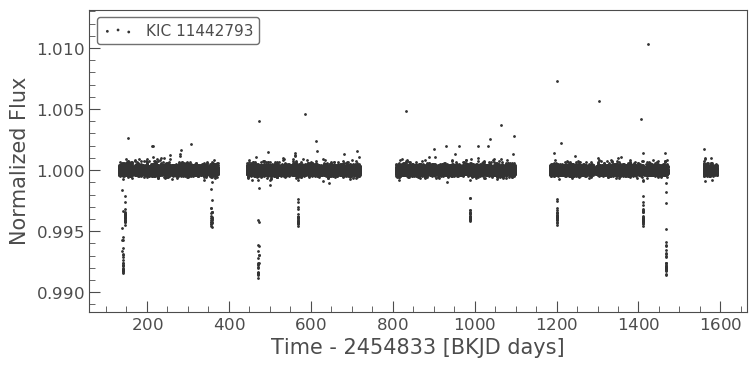

In [592]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();

In [887]:
def planet_hunting(clc, num):
    plt.style.use("seaborn-white")
    
    # Step 1: Calculate periodogram
    #chose period values based on the Exoplanet Archive
    periodogram = clc.to_periodogram(method = "bls", period = np.arange(50,350,0.01))
    periodogram.plot()

    #Step 2: Find strongest period
    print("Period for planet %i: %s" % (num, periodogram.period_at_max_power))

    #Step 3: Fold on that period (to check if it looks like a planet)
    folded_lc = clc.fold(period = periodogram.period_at_max_power, t0 = periodogram.transit_time_at_max_power).errorbar()
    folded_lc.set_xlim(-0.01, 0.01)

    #Step 4: Mask lightcurve to remove transit
    transits_lc = []
    for i in range(0,100):
        if (periodogram.transit_time_at_max_power + (periodogram.period_at_max_power.value*i)) <= (np.max(clc.time) + 200):
            transits_lc.append(periodogram.transit_time_at_max_power + (periodogram.period_at_max_power.value*i))

    #Looking at transits as a sanity check that it's all working
    plt.figure(figsize = (14,7))
    plt.scatter(clc.time, clc.flux, label = "Planet %i" % (num))
    plt.vlines(transits_lc, 0.998, 1.002, color = "magenta", label = "Transits")
    plt.ylim(.994, 1.005)
    plt.legend(loc = "best", prop = {"size":15})
    plt.tick_params("both", labelsize = 15)
    
    
    bool_mask = np.ones(len(clc.time))
    for transit_times in transits_lc:
        idx = (np.abs(clc.time - transit_times)).argmin()
        tol = 100
        index_range = np.arange(idx - tol, tol + idx,1)
        for indices in index_range:
            if (indices < len(clc.time)):
                bool_mask[indices] = 0

    #Step 5: Remove that fit from the original light curve            
    bool_mask = np.array(bool_mask, dtype = "bool")
    t, f, e = clc.time[bool_mask], clc.flux[bool_mask], clc.flux_err[bool_mask]
    new_clc = lk.lightcurve.KeplerLightCurve(t, f, e)

    return new_clc 

### Finding planets!

Period for planet 1: 331.60999999994397 d


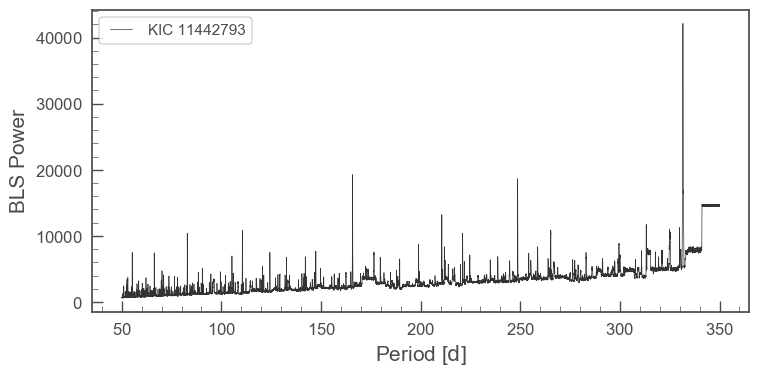

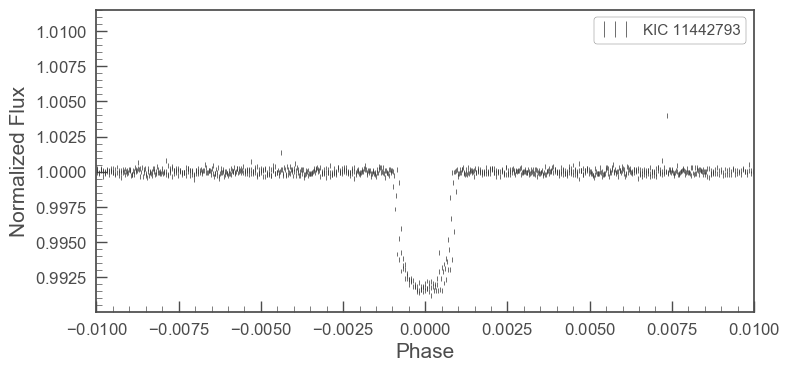

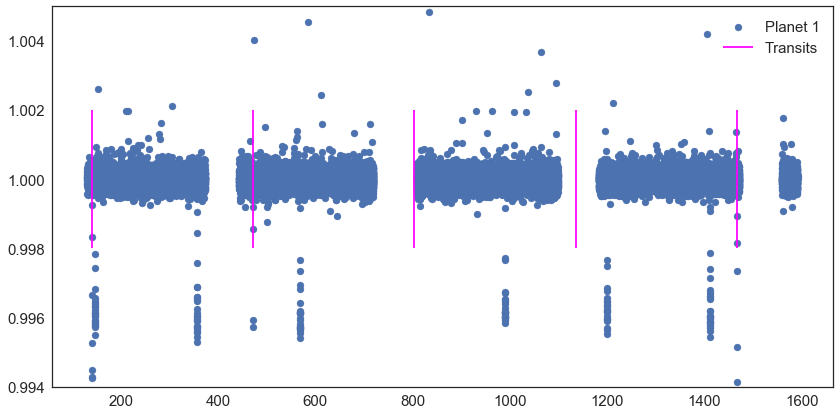

In [888]:
clc_2 = planet_hunting(clc, 1) 

Period for planet 2: 210.59999999996805 d


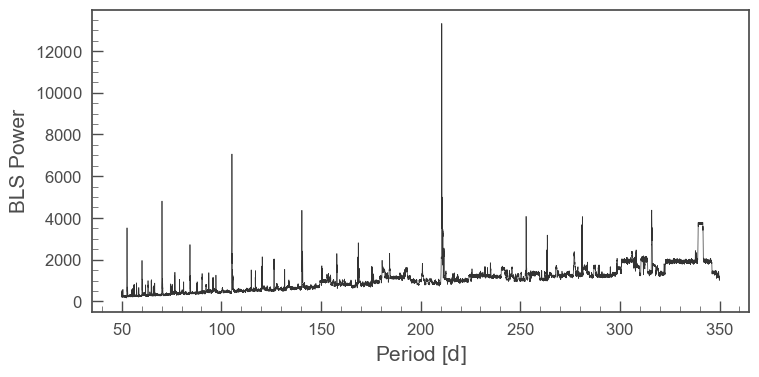

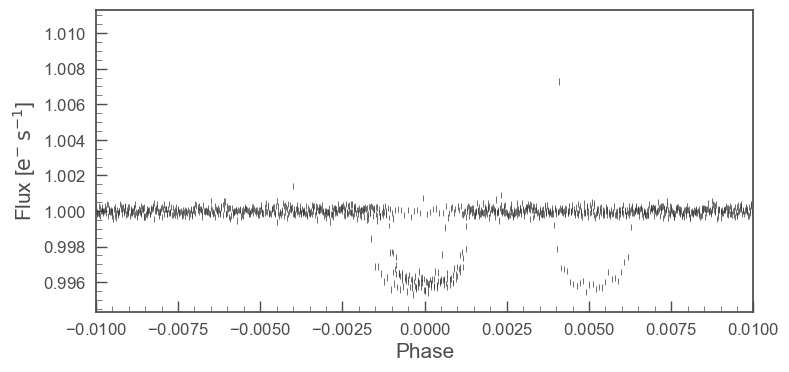

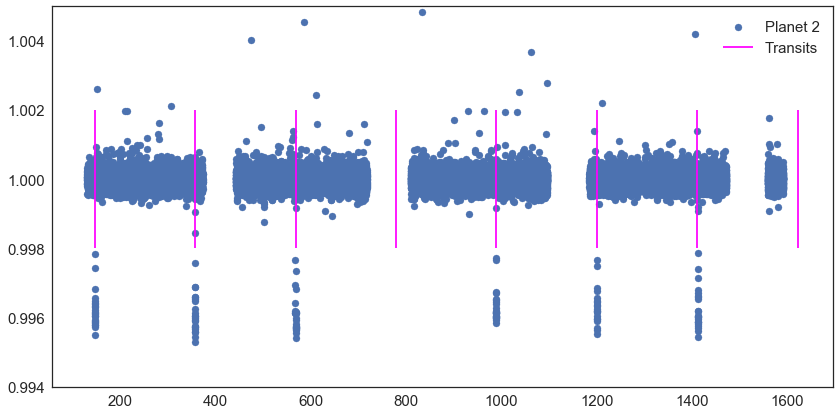

In [889]:
clc_3 = planet_hunting(clc_2, 2)

Period for planet 3: 59.73999999999806 d


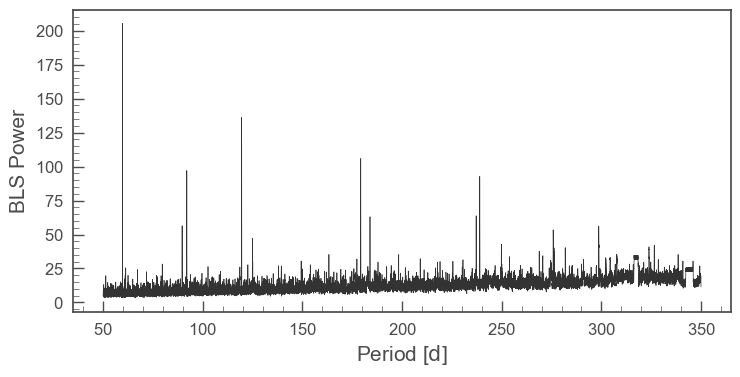

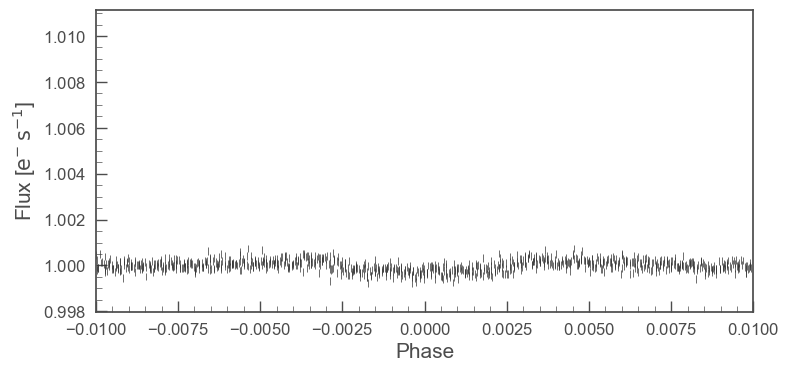

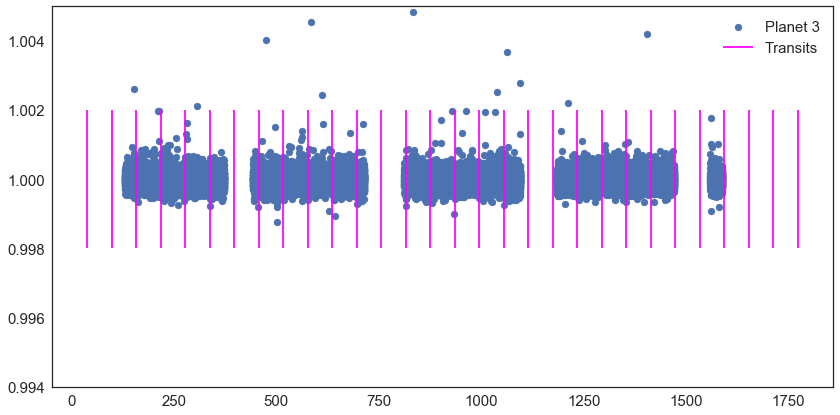

In [890]:
clc_4 = planet_hunting(clc_3, 3)

Period for planet 4: 91.93999999999166 d


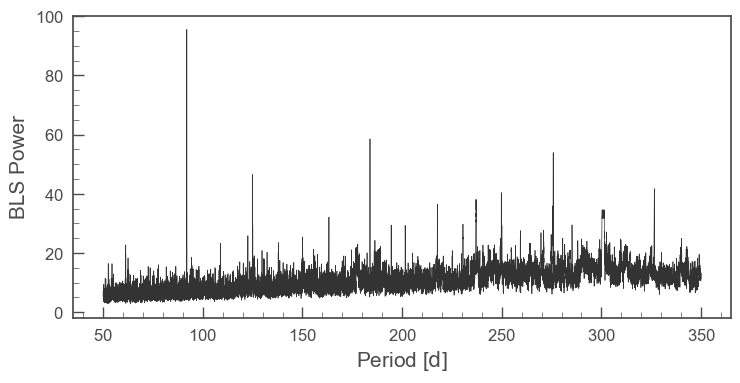

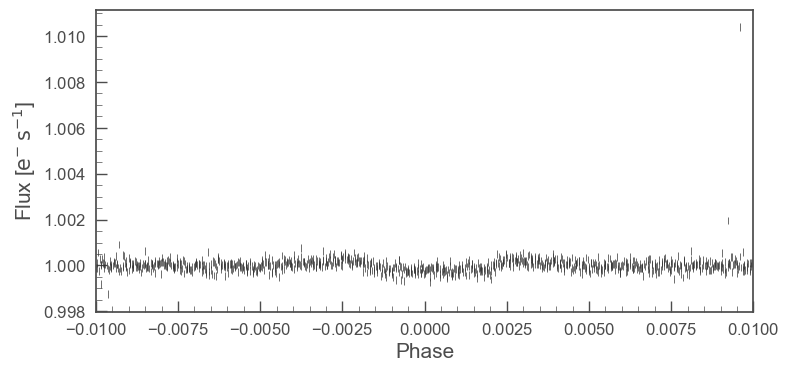

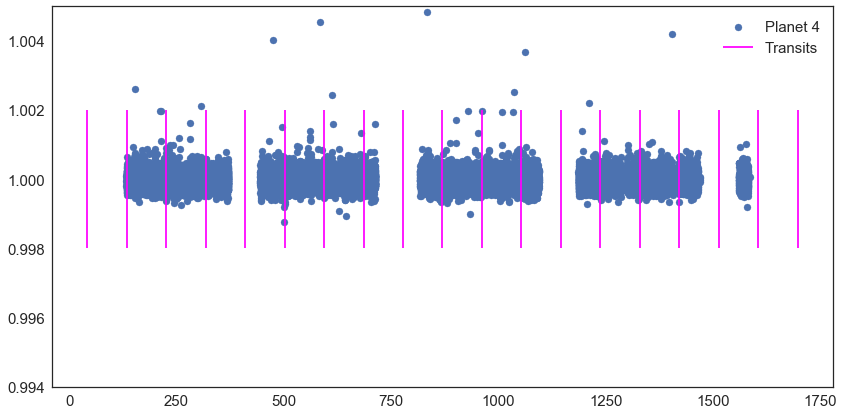

In [891]:
clc_5 = planet_hunting(clc_4, 4)

Period for planet 5: 124.9199999999851 d


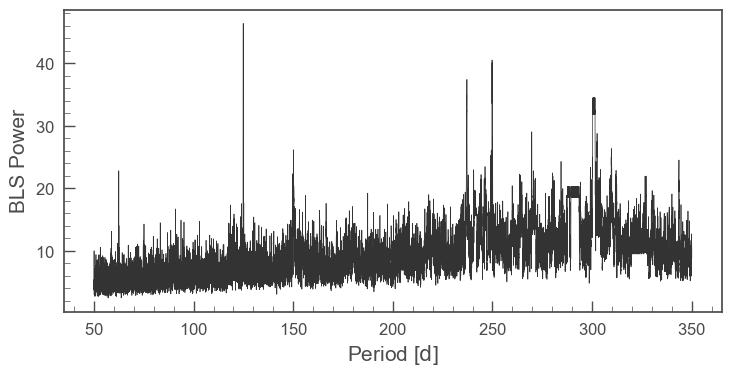

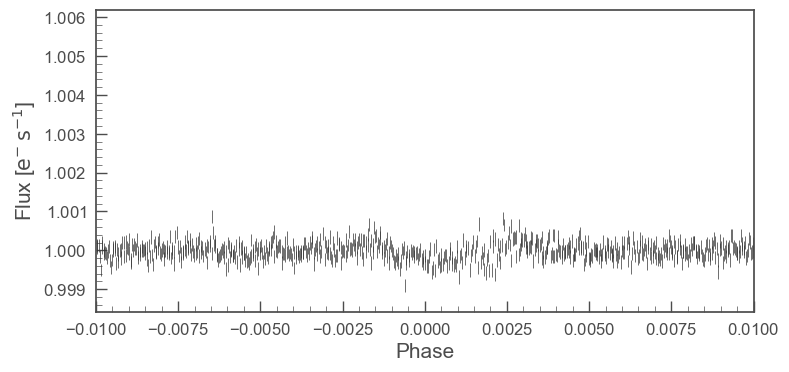

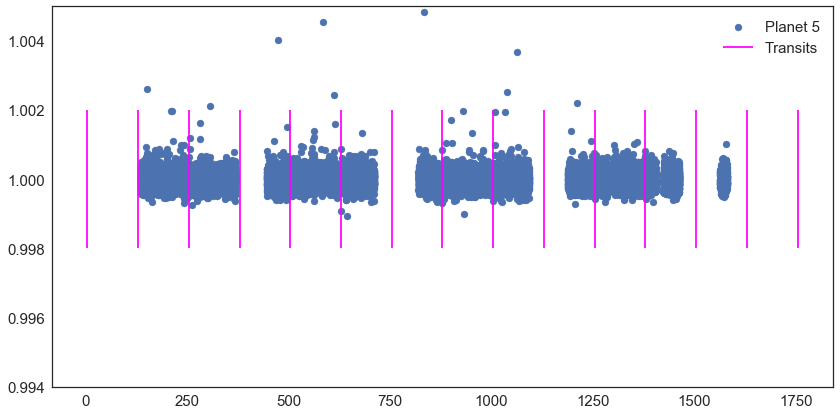

In [892]:
clc_6 = planet_hunting(clc_5, 5)

## Conclusion

### After much(!) trial and error, I'm happy to say I was able to find 5 out of the 8 planets. Comparing the period values I got to the Exoplanet Archive data on Kepler-90, I found planets D, E, F, G, H.  